In [1]:
from stable_baselines3 import DQN, PPO
from utils import *
from data_logger import DataLogger
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
#Loading parameters
ep, lp, hp = get_params() #params["environment"], params["logging"], params["hyperparameters"]
hp_algo = hp['dqn/ddqn']

In [3]:
#Environment
env = get_env(game=ep["game"], level=ep["level"], action_space=ep["action_space"])
env = apply_wrappers(env, skip=ep["skip"], gray_scale=ep["gray_scale"], shape=ep["frame_shape"], num_stack=ep["num_stack"])
next_state = env.reset()
print(next_state.shape)

(4, 84, 84)


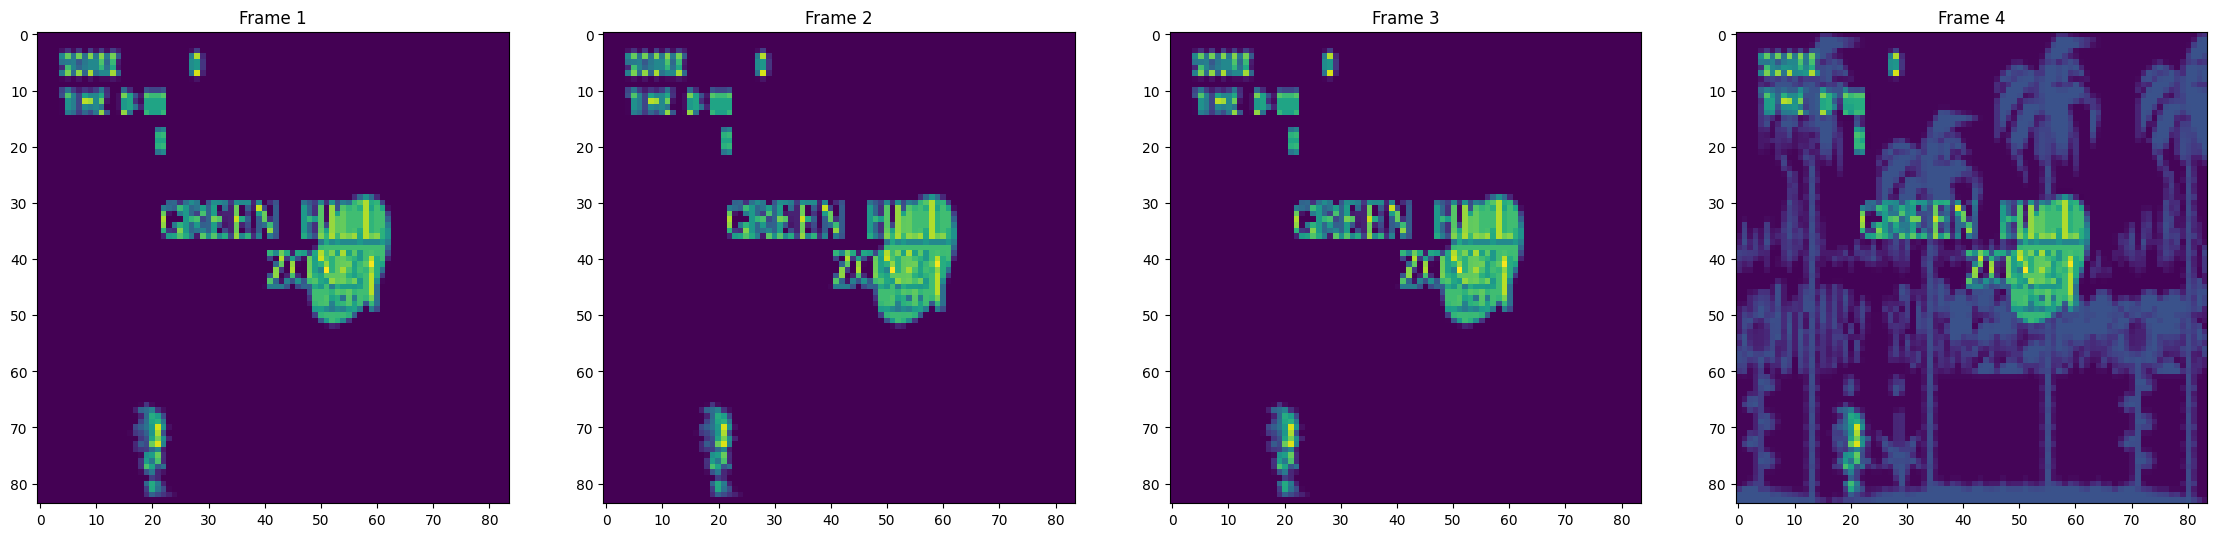

In [4]:
from utils import *
next_state, reward, done, info = env.step(get_action_sample(env))
plot_sequence_observations(next_state)

In [5]:
#Logging
from stable_baselines3.common.callbacks import BaseCallback
import collections

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting winrate in tensorboard and saving hyperparameters.
    """
    def __init__(self, verbose=0, game="mario"):
        super().__init__(verbose)
        self.reward_history = []
        self.win_rate_history = []
        self.episodes_prev_act = collections.deque([0, 0], maxlen=2)
        self.win_prev_act = collections.deque([0, 0], maxlen=2)
        self.game = game

    def _on_step(self) -> bool:
        self.episodes_prev_act.append(self.model._episode_num)
        if self.game=="mario":
            self.win_prev_act.append(int(self.locals["infos"][0]["flag_get"]))
        elif self.game=="sonic":
            self.win_prev_act.append(int(self.locals["dones"][0] and (self.locals["infos"][0]["lives"]==self.locals["infos"][0]["prev_lives"])))
        
        if self.episodes_prev_act[0] != self.episodes_prev_act[1]:
            self.logger.record("rollout/winrate", self.win_prev_act[0])
            self.win_rate_history.append(self.win_prev_act[0])        
            self.reward_history.append(self.model.ep_info_buffer[-1]["r"])        
        return True   

logger = DataLogger(env, hp, model=hp_algo["model"])
checkpoint_callback = CheckpointCallback(save_freq=lp["n_time_steps_save_model"], save_path=logger.folder_path_models, name_prefix="chkpt")#saving the model periodically
eval_callback = EvalCallback(env, best_model_save_path=logger.folder_path_models, log_path=logger.folder_path_models, eval_freq=lp["evaluate_best_model_every"], deterministic=True, render=False)#evaluating the model periodically and saving the best one
log_callback = TensorboardCallback(game = ep["game"])

In [6]:
#Hyperparams DQN
model = DQN("CnnPolicy",
            env,
            double_dqn = (hp_algo["model"]=="DDQN"), 
            buffer_size = hp_algo["buffer_size"],
            batch_size = hp_algo["batch_size"],
            learning_starts = hp_algo["learning_starts"],
            learning_rate = hp_algo["learning_rate"],
            gamma = hp_algo["discount_factor"],  
            exploration_fraction = hp_algo["exploration_fraction"],
            exploration_final_eps = hp_algo["exploration_final_eps"],
            train_freq = hp_algo["train_freq"],                    
            target_update_interval = hp_algo["target_update_interval"],   
            tensorboard_log = logger.folder_path_train,
            verbose = 1,
            device = device
            )

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [7]:
#model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=logger.folder_path_train, learning_rate=hp_algo["learning_rate"])

In [8]:
model.learn(hp_algo["time_steps"],
            callback=[log_callback, checkpoint_callback, eval_callback],
            tb_log_name="train_freq_1")

Logging to logs\SonicTheHedgehog-Genesis\DDQN\20240201234341\train\train_freq_1_1


e:\10mociclo\Applied\RL_Sonic-TheHedgehog\venv38\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=25000, episode_reward=1996.73 +/- 0.00
Episode length: 430.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 430      |
|    mean_reward      | 2e+03    |
| rollout/            |          |
|    exploration_rate | 0.755    |
|    winrate          | 0        |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.00025  |
|    loss             | 0.812    |
|    n_updates        | 23999    |
----------------------------------
New best mean reward!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8.51e+03 |
|    ep_rew_mean      | 869      |
|    exploration_rate | 0.667    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 88       |
|    time_elapsed     | 384      |
|    total_timesteps  | 34025    |
| train/              |          |
|    learning

KeyboardInterrupt: 

In [10]:
logger.total_rewards = log_callback.reward_history
logger.wins = log_callback.win_rate_history
logger.close()

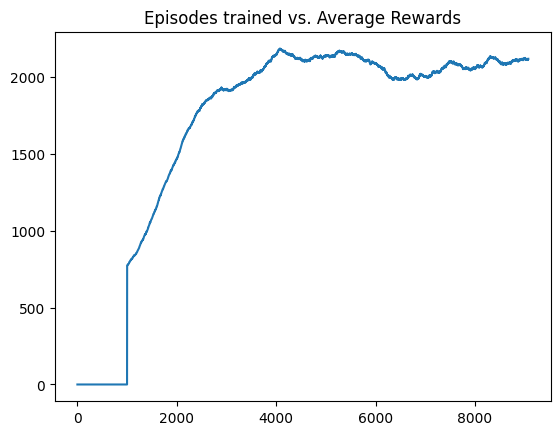

In [15]:
plot_average_reward(logger.total_rewards, title="Episodes trained vs. Average Rewards", n_average=1000)

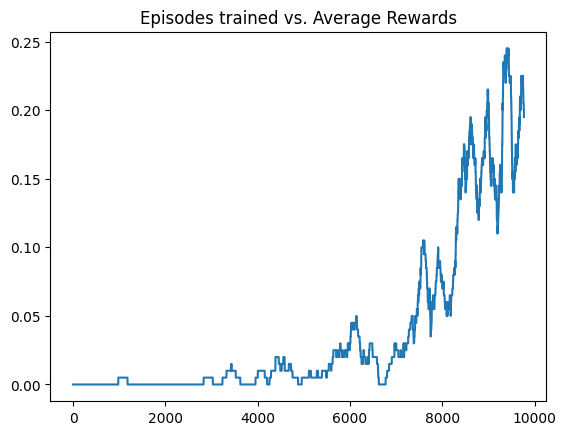

In [16]:
import pickle
with open(r"logs/SuperMarioBros-1-1-v0/DDQN/20240131041250/train/total_wins", 'rb') as f:
    rews = pickle.load(f)
plot_average_reward(rews, title="Episodes trained vs. Average Rewards", n_average=200)

In [23]:
# Load the trained model
model = DQN.load(r"logs\SuperMarioBros-1-1-v0\DDQN\20240131181550\checkpoints\best_model.zip")


env = get_env(game=ep["game"], level=ep["level"], action_space=ep["action_space"])
env = apply_wrappers(env, skip=ep["skip"], gray_scale=ep["gray_scale"], shape=ep["frame_shape"], num_stack=ep["num_stack"], library=hp_algo["library"])
# Test the model
obs = env.reset()
done = False
while not done:
    action, _ = model.predict(np.array(obs))
    print(action)
    obs, _, done, _ = env.step(int(action))
    env.render()

env.close()

3
3
3
3
3
2
2
2
4
4
2
4
4
4
2
2
4
3
3
3
4
3
4
1
3
2
2
3
3
3
3
1
2
4
4
2
2
4
0
1
3
2
3
3
3
2
3
4
1
2
2
3
4
2
2
1
3
3
1
3
1
3
2
2
4
3
0
4
